# Problem sheet 2 (Group 33)


## Setup stuff 

In [1]:
#set up stuff 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers(df,lq=0,hq=1):
    #df: Dataframe with only the variables to trim
    # lq: lowest quantile. hq:Highest quantile
    columns = pd.Series(df.columns.values).tolist()
    for serie in columns:
        df["houtliers_"+serie] = df[serie].quantile(hq)
        df[df[serie]>df["houtliers_"+serie]] = np.nan
        df["loutliers_"+serie] = df[serie].quantile(lq)
        df[df[serie]<df["loutliers_"+serie]]= np.nan
        del df["houtliers_"+serie], df["loutliers_"+serie]
    return df


def gini(array):
    # from: https://github.com/oliviaguest/gini
    #http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm 
    array = np.array(array)
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array += np.amin(array) #non-negative
    array += 0.0000001 #non-0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) 
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) 


def data_stats(data, percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]):
    ### Compute mean, sd, min, max, quintiles and Gini of the states in the state list.
    # Inputs -----------------
    # Dataframe
    
    #Obtain the describtive statistics for the state variables.    
        
    summary = data.describe(percentiles)
    summary.reset_index(inplace=True)
        
    #Generate Gini statistic:
    gini_stat = np.empty(len(data.columns)).reshape(1,len(data.columns))
    
    for i, var in enumerate(data.columns):
        gini_stat[:,i] = gini(data[var].dropna())
                
    data_gini = pd.DataFrame(gini_stat, columns=data.columns)    
    data_gini.reset_index(inplace=True)
    data_gini['index'] = 'Gini'
    summary = summary.append(data_gini, ignore_index=True)
    summary.set_index('index', inplace=True)
    
    return summary


def plot_cond_log_distr(data, variable1, variable2, save=False):
        fig, ax = plt.subplots()
        a = data[variable2].unique()
        for value in a:           
            sns.distplot((np.log(data.loc[data[variable2] == value][variable1]).replace([-np.inf, np.inf], np.nan)).dropna()-np.mean((np.log(data[variable1]).replace([-np.inf, np.inf], np.nan)).dropna()), label=variable2+str(value))
           
        plt.title('Distribution of '+variable1+' in Uganda')
        plt.xlabel(variable1)
        ax.legend()
        
        return plt.show()
        
def plot_cum_cond_log_distr(data, variable1, variable2, save=False):
        fig, ax = plt.subplots()
        a = data[variable2].unique()
        for value in a:           
            sns.distplot((np.log(data.loc[data[variable2] == value][variable1]).replace([-np.inf, np.inf], np.nan)).dropna()-np.mean((np.log(data[variable1]).replace([-np.inf, np.inf], np.nan)).dropna()), label=variable2+str(value), hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
        plt.title('Cumulative Distribution of '+variable1+' in Uganda')
        plt.xlabel(variable1)
        ax.legend()
        return plt.show()       




## Exercise 1 
1a) Are there duplicate households in the data? That is check if there are repeated observations in the unique household identifier variable (’hhid’). How many observations are there in the data?

In [12]:
#import data
df1 = pd.read_excel("UNPS_1112_PS2.xls")

#1a
#count number of duplicates in column hhid 
print("the number of duplicates is ",df1.hhid.duplicated().sum() )

print("there are ", len(df1["hhid"]), "observations.")


the number of duplicates is  0
there are  2613 observations.


### 1b) 
Present some basic summary statistics for the following variables: head_gender, head _age, familysize, consumption, income, wealth. Comment your results in 2 lines. In particular, you might mention if there are missing observations or potential outliers for some of the variables.

- head_gender	gender of the household head: 1 if male, 2 if female.
- head_age	age of the household head 
- consumption	total household consumption (excluding durables). In 2013 dollars, adjusted for inflation.
- income -total household income. In 2013 dollars, adjusted for inflation.
- wealth - total household wealth. In 2013 dollars, adjusted for inflation.




In [13]:
#check columns
#print(df1.keys())

#summary statistics 
df1[['head_gender','head_age','income','wealth','consumption']].describe()

,head_gender,head_age,income,wealth,consumption
count,2597.000000,2597.000000,2613.000000,2613.000000,2613.000000
mean,1.314209,46.068156,1860.075795,4912.698146,1803.792687
std,0.464289,15.068960,2607.517603,8359.886497,1308.742941
min,1.000000,14.000000,27.486921,0.000000,250.305506
25%,1.000000,34.000000,471.204368,720.019916,918.324958
50%,1.000000,44.000000,1061.194208,2108.598380,1426.614855
75%,2.000000,56.000000,2234.800590,5221.939857,2296.859516
max,2.000000,100.000000,52137.736864,76396.339917,8369.898484


In [5]:
#then do a grouby gender 
df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()

,head_age,income,wealth,consumption
head_gender,,,,
1.0,44.388546,2061.184846,5278.582949,1898.303754
2.0,49.734069,1417.438044,4072.893135,1593.261206


In [29]:
#Checking for na values
print('number of NA values')
print(df1[['head_gender','head_age','income','wealth','consumption']].isna().sum())
#from the observation there are null values for head_gender and head_age 
#for a more accurate representation of gender statistics we will remove the corresponding rows from the dataframe

#drop rows with NaNs corresponding to the 2 above (for a more accurate representation of gender
#  statistics we will remove the corresponding rows from the dataframe)


df1.dropna(subset=['head_gender', 'head_age'], inplace=True)

#check the number of outliers 
#we define an outlier to be an observation more than 3 s.d
#from the mean 
print("\n", 'number of outliers:')
col = ['head_gender','head_age','income','wealth','consumption']
for i in col:
    mean = df1[i].mean()
    sd = df1[i].std()
    outlier = df1[i] > mean+(3*sd) 
    sum_outliers = outlier.sum()
    
    print('for column: {}'.format(i))
    print("the number of outliers are", sum_outliers, "\n")
    



number of NA values
head_gender    0
head_age       0
income         0
wealth         0
consumption    0
dtype: int64

 number of outliers:
for column: head_gender
the number of outliers are 0 

for column: head_age
the number of outliers are 1 

for column: income
the number of outliers are 60 

for column: wealth
the number of outliers are 71 

for column: consumption
the number of outliers are 29 



In [16]:
#we can also clean the dataframe of possible outliers 
#remove outliers that lie more 
#than 3 standard deviations away from the mean

col = ['head_age','income','wealth','consumption']
for i in col:
    mean = df1[i].mean()
    sd = df1[i].std()
    df1 = df1[(df1[i] <= mean+(3*sd))] 
    
# #this returns a dataframe with the outliers removed

#instead we use albert's function to remove outliers


In [17]:
#after cleaning we apply the previous summary statisitcs:

df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()

,head_age,income,wealth,consumption
head_gender,,,,
1.0,44.144753,1667.008449,3916.227601,1703.251272
2.0,49.414286,1205.710597,2924.827617,1445.140776


### 1c

Using the head_gender variable, create a dummy variable for household head being female (1=female, 0=male). Be careful with missing values. What is the proportion of households where the head is female?

In [11]:
df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()

,head_age,income,wealth,consumption
head_gender,,,,
1.0,44.144753,1667.008449,3916.227601,1703.251272
2.0,49.414286,1205.710597,2924.827617,1445.140776


In [19]:
#previously we have removed missing values from the 
#data frame

#generate female dummy variable column , the output 

female = pd.get_dummies(df1['head_gender'])

# remove column corresponding to male == 1 
female = female.drop([1.0],axis = 1) 


proportion = female.mean()
print('proportion of females =', proportion) 

#rename column 2.0 to female and concatate to df1
female.rename(columns={2.0:'female'}, inplace=True)
df1 = pd.concat([df1, female], axis=1)


proportion of females = 2.0    0.317133
dtype: float64
proportion of females = 2.0    0.317133
dtype: float64


### 1d 


head_age	income	wealth	consumption
head_gender				
1.0	44.388546	2061.184846	5278.582949	1898.303754
2.0	49.734069	1417.438044	4072.893135	1593.261206
Both male and female lead households had similar consumption levels, with male lead households slightly higher. There was a larger discrepancy in wealth, as male lead households had an average wealth of $1,200 more. Male households also had higher average income, though to a lesser extent than wealth. On average, female household leaders were 5 years older than male ones.

In [20]:

df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()


,head_age,income,wealth,consumption
head_gender,,,,
1.0,44.144753,1667.008449,3916.227601,1703.251272
2.0,49.414286,1205.710597,2924.827617,1445.140776


In [36]:
# Exercise 2

l1 = ['consumption','income','wealth']
#checking NAs and zeros in wealth 
for i in l1:
    print("number of NAs in [i]",df1[i].isna().sum())
    num_zeros = (df1[i] == 0).sum()
    print("Number of zeros in [i]: ", num_zeros, "\n")

#to avoid infinity values when we log, we will 

#remove rows with zeros in wealth column so there are no infinity values 
df1 = df1[df1["wealth"] != 0]

number of NAs in [i] 0
Number of zeros in [i]:  0 

number of NAs in [i] 0
Number of zeros in [i]:  0 

number of NAs in [i] 0
Number of zeros in [i]:  9 



c:\Users\arifs\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\arifs\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


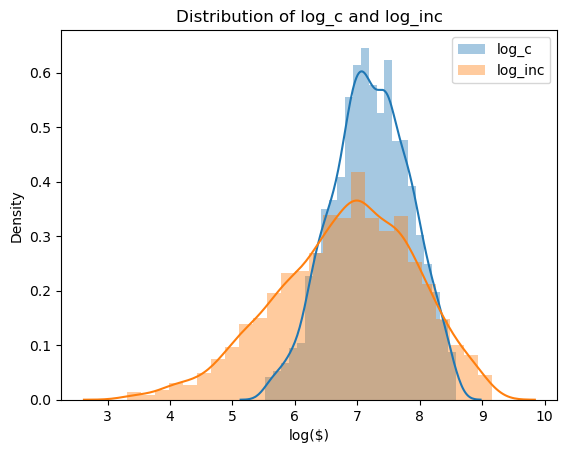

In [37]:
import seaborn as sns 

#define variables 
log_c = np.log(df1[['consumption']]) #
log_inc = np.log(df1[['income']]) #
log_w = np.log(df1[['wealth']])




#plotting
fig, ax = plt.subplots()
sns.distplot(log_c, label='log_c')
sns.distplot(log_inc, label='log_inc')
plt.title('Distribution of log_c and log_inc')
ax.legend()
plt.xlabel('log($)')
plt.show()


### 2a 

#The distributions resemble normal distribution 
#log_inc is more evenly distributed due to shape of the graph being flatter

### 2b

A commonly used statistic to measure inequality is the variance of the logs. Compute the variance of the log of consumption, of the log of income, and of the log of wealth. How do these measures of inequality in Uganda compare to the same measures of inequality in the United States? Use table 3, column 5–PSID in De Magalhães, L., & Santaeulàlia-Llopis, R. (2018) for the comparison.



number of NAs in wealth 0
Number of zeros in wealth:  0


In [39]:
#variance
l1 = [log_c,log_inc,log_w]
vars = []


for i in l1:
    vars.append(i.var())
    
print(vars)

[consumption    0.385102
dtype: float64, income    1.200195
dtype: float64, wealth    2.402457
dtype: float64]
